In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [10]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf

2024-05-14 21:20:39.028845: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 21:20:39.028971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 21:20:39.293174: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
train_df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv')
test_df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv')
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**Ce code charge deux fichiers CSV, train.csv et test.csv, à partir du chemin spécifié /kaggle/input/jigsaw-toxic-comment-classification-challenge/, en utilisant la bibliothèque pandas. Ensuite, il affiche les cinq premières lignes du DataFrame train_df à l'aide de la méthode head(). Cela permet d'avoir un aperçu des données contenues dans le DataFrame.**

**Check null comment**

In [12]:
no_comment = train_df[train_df['comment_text'].isnull()]
no_toxic = train_df[train_df['toxic'].isnull()]
no_severe_toxic = train_df[train_df['severe_toxic'].isnull()]
no_obscene = train_df[train_df['obscene'].isnull()]
no_threat = train_df[train_df['threat'].isnull()]
no_insult = train_df[train_df['insult'].isnull()]
no_identity_hate = train_df[train_df['identity_hate'].isnull()]

print(len(no_comment),len(no_toxic), len(no_severe_toxic), len(no_obscene), len(no_threat), len(no_insult), len(no_identity_hate))

0 0 0 0 0 0 0


**Ce code identifie les lignes où certaines colonnes spécifiques ont des valeurs nulles dans le DataFrame train_df. Il compte ensuite le nombre de lignes où chaque colonne est nulle, puis affiche ces comptages. Cela peut être utile pour vérifier s'il y a des valeurs manquantes dans les données.**

In [13]:
no_comment = test_df[test_df['comment_text'].isnull()]
len(no_comment)

0

**Ce code identifie les lignes où la colonne 'comment_text' du DataFrame test_df contient des valeurs nulles, puis il compte le nombre de ces lignes. Cela permet de vérifier s'il y a des commentaires manquants dans le jeu de données de test.**

**clean data**

In [14]:
#reference from HOON BENG
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

# clean comment_text in train_df 
train_df['comment_text'] = train_df['comment_text'].map(lambda com : clean_text(com))
# clean comment_text in test_df 
test_df['comment_text'] = test_df['comment_text'].map(lambda com : clean_text(com))

**Ce code définit une fonction clean_text qui prend du texte en entrée et le nettoie en effectuant les opérations suivantes :**

**Convertit le texte en minuscules.
Remplace les apostrophes contractées par leur forme complète (par exemple, "what's" devient "what is").
Supprime les caractères non alphanumériques.
Réduit les espaces blancs multiples en un seul espace.
Supprime les espaces blancs à la fin du texte.
Ensuite, il applique cette fonction de nettoyage à la colonne 'comment_text' des DataFrames train_df et test_df. Cela permet de normaliser le texte et de le préparer pour le traitement ultérieur.**

**tf-idf**

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_X = train_df['comment_text']
test_X = test_df['comment_text']

vectorizer = TfidfVectorizer(max_features=5000) 
train_vect = vectorizer.fit_transform(train_X)
test_vect = vectorizer.transform(test_X)

train_vect.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])


**Ce code utilise le module TfidfVectorizer de la bibliothèque scikit-learn pour convertir les commentaires textuels en vecteurs de caractéristiques TF-IDF (Term Frequency-Inverse Document Frequency).**

**Il extrait les commentaires textuels de train_df et test_df dans les variables train_X et test_X respectivement.
Ensuite, il crée un objet TfidfVectorizer avec un maximum de 5000 fonctionnalités (mots) en utilisant la ligne vectorizer = TfidfVectorizer(max_features=5000).
Il utilise ensuite la méthode fit_transform pour transformer les données d'entraînement train_X en vecteurs TF-IDF, et transform pour transformer les données de test test_X.
Enfin, il convertit les vecteurs résultants en matrices denses à l'aide de la méthode toarray().**

**Check Imbalance Data**

In [16]:
from collections import Counter
print('toxic',sorted(Counter(train_df['toxic']).items()))
print('severe_toxic',sorted(Counter(train_df['severe_toxic']).items()))
print('obscene',sorted(Counter(train_df['obscene']).items()))
print('threat',sorted(Counter(train_df['threat']).items()))
print('insult',sorted(Counter(train_df['insult']).items()))
print('identity_hate',sorted(Counter(train_df['identity_hate']).items()))

toxic [(0, 144277), (1, 15294)]
severe_toxic [(0, 157976), (1, 1595)]
obscene [(0, 151122), (1, 8449)]
threat [(0, 159093), (1, 478)]
insult [(0, 151694), (1, 7877)]
identity_hate [(0, 158166), (1, 1405)]



**Ce code utilise la bibliothèque collections pour compter le nombre d'occurrences de chaque classe dans les colonnes 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult' et 'identity_hate' du DataFrame train_df. Il imprime ensuite les résultats triés par classe. Cela permet de visualiser la distribution des différentes classes dans les données d'entraînement.**

**Smote**

In [17]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [19]:
from imblearn.over_sampling import SMOTE

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
oversampled_data = {}

smote = SMOTE(sampling_strategy='auto', random_state=42)

for label in labels:
    y = train_df[label].values  

    # SMOTE 
    X_resampled, y_resampled = smote.fit_resample(train_vect, y)

    # oversampled
    oversampled_data[label] = (X_resampled, y_resampled)

    unique, counts = np.unique(y_resampled, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print(f'label : {label}')
    print('0 =>', class_counts[0])
    print('1 =>', class_counts[1])

label : toxic
0 => 144277
1 => 144277
label : severe_toxic
0 => 157976
1 => 157976
label : obscene
0 => 151122
1 => 151122
label : threat
0 => 159093
1 => 159093
label : insult
0 => 151694
1 => 151694
label : identity_hate
0 => 158166
1 => 158166


**Ce code utilise la méthode SMOTE (Synthetic Minority Over-sampling Technique) de la bibliothèque imbalanced-learn pour effectuer un sur-échantillonnage des classes minoritaires dans les données d'entraînement.**

**Il commence par définir une liste labels contenant les noms des classes à équilibrer : 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', et 'identity_hate'.**

**Ensuite, pour chaque classe, il applique SMOTE en utilisant les données d'entraînement train_vect et les étiquettes correspondantes de la classe spécifique. Les données d'entraînement sont ainsi sur-échantillonnées pour équilibrer les classes.**

**Les données sur-échantillonnées sont stockées dans le dictionnaire oversampled_data, où chaque classe est associée à ses données d'entraînement sur-échantillonnées. Enfin, il imprime le nombre de occurrences de chaque classe avant et après le sur-échantillonnage. Cela permet de vérifier l'efficacité du sur-échantillonnage en équilibrant les classes.**

**softmax**

Category: toxic
Test accuracy: 0.9302732581310322
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     28854
           1       0.92      0.94      0.93     28857

    accuracy                           0.93     57711
   macro avg       0.93      0.93      0.93     57711
weighted avg       0.93      0.93      0.93     57711

Category: severe_toxic
Test accuracy: 0.9780031966577519
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     31656
           1       0.96      1.00      0.98     31535

    accuracy                           0.98     63191
   macro avg       0.98      0.98      0.98     63191
weighted avg       0.98      0.98      0.98     63191

Category: obscene
Test accuracy: 0.9543747621962315
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     30250
           1       0.95      0.96      0.95     30199

    accuracy           

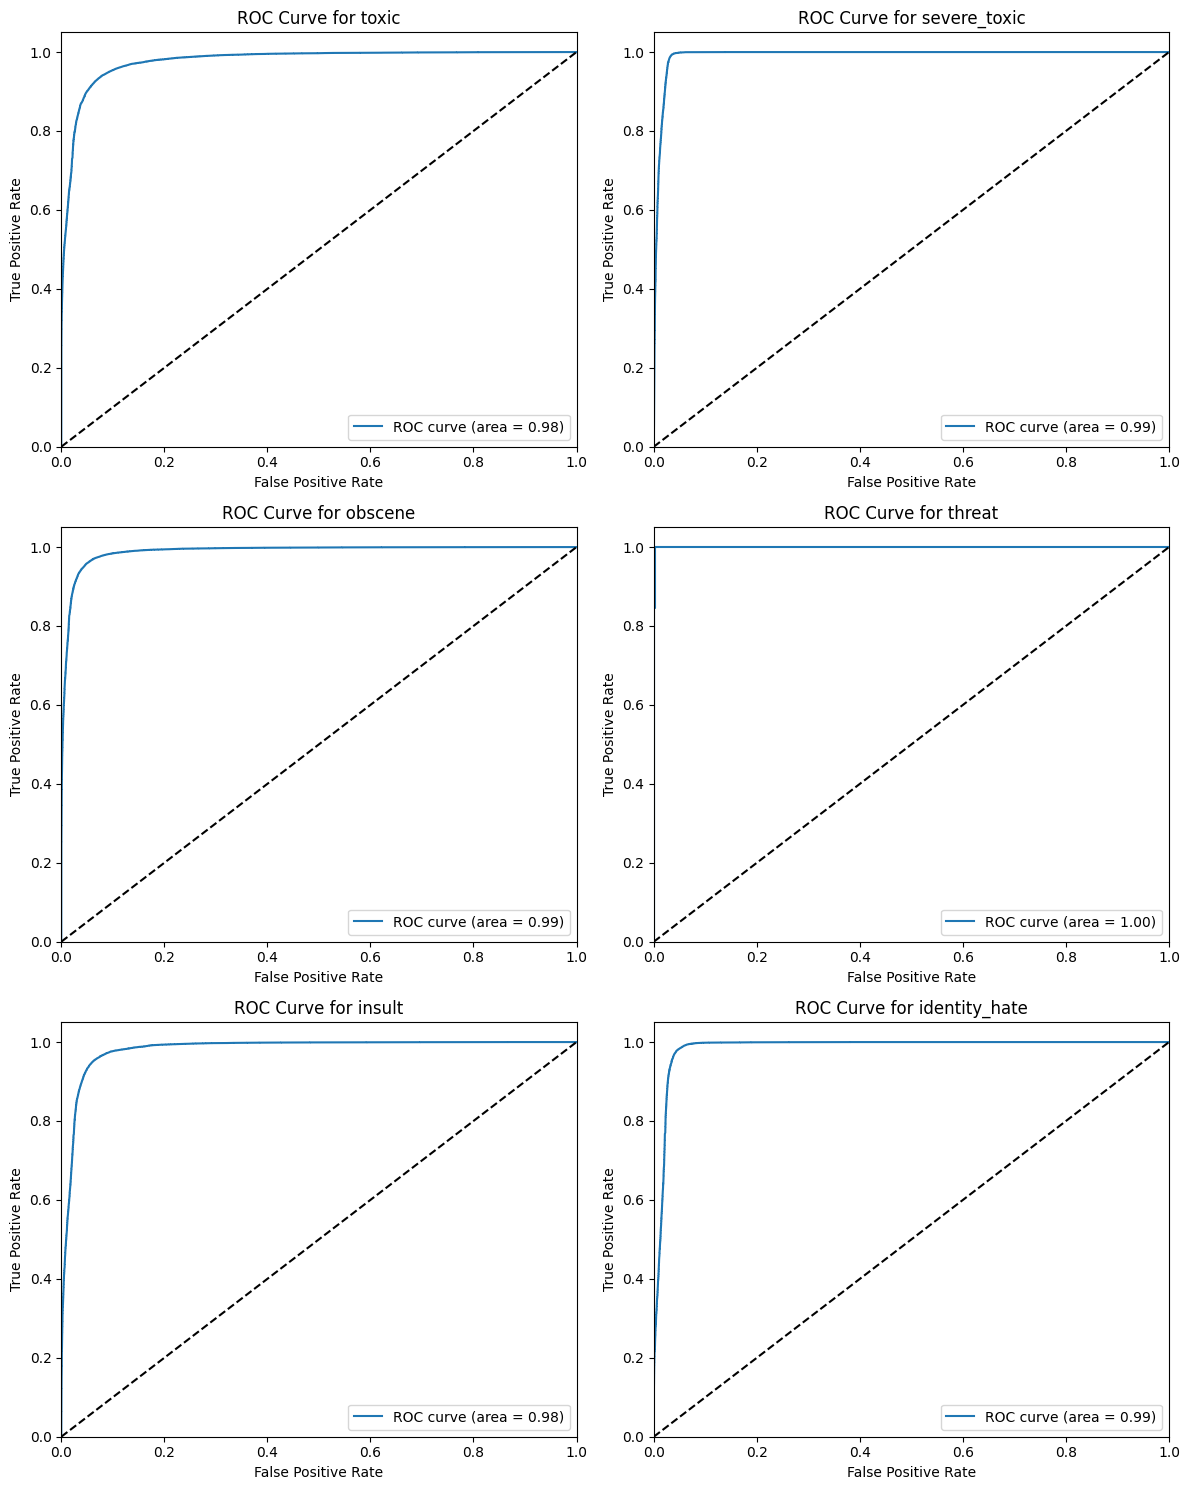

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
models = {}

plt.figure(figsize=(12, 15))

for i, label in enumerate(labels):
    X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(
        oversampled_data[label][0], oversampled_data[label][1], test_size=0.2, random_state=42
    )

    softmax_regression_model_label = LogisticRegression(
        multi_class='multinomial', solver='lbfgs', max_iter=1000
    )
    softmax_regression_model_label.fit(X_train_label, y_train_label)

    y_pred_label = softmax_regression_model_label.predict(X_test_label)
    y_pred_prob = softmax_regression_model_label.predict_proba(X_test_label)[:, 1]

    accuracy_label = accuracy_score(y_test_label, y_pred_label)
    report_label = classification_report(y_test_label, y_pred_label)

    fpr, tpr, thresholds = roc_curve(y_test_label, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    print(f'Category: {label}')
    print(f'Test accuracy: {accuracy_label}')
    print(report_label)

    models[label] = softmax_regression_model_label

    plt.subplot(3, 2, i + 1)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {label}')
    plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

**Ce code entraîne un modèle de régression logistique multinomiale pour chaque classe de labels (toxic, severe_toxic, obscene, threat, insult, identity_hate) en utilisant les données d'entraînement sur-échantillonnées. Ensuite, il évalue la performance de chaque modèle en termes de précision, et trace la courbe ROC (Receiver Operating Characteristic) pour chaque classe.**

**Plus précisément, pour chaque classe :**

**Divise les données sur-échantillonnées en ensembles d'entraînement et de test.
Entraîne un modèle de régression logistique multinomiale sur les données d'entraînement.
Prédit les étiquettes de test et calcule la précision ainsi que le rapport de classification.
Calcule la courbe ROC et l'AUC (Area Under the Curve) pour évaluer la performance du modèle en termes de trade-off entre le taux de vrais positifs et le taux de faux positifs.
Affiche les résultats d'évaluation et trace la courbe ROC pour chaque classe.
Enfin, il affiche les courbes ROC dans une figure matplotlib pour permettre une comparaison visuelle de la performance des modèles pour chaque classe.**

In [41]:
from sklearn.metrics import confusion_matrix
import numpy as np

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
models = {}

for label in labels:
    X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(oversampled_data[label][0], oversampled_data[label][1], test_size=0.2, random_state=42)

    softmax_regression_model_label = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    softmax_regression_model_label.fit(X_train_label, y_train_label)
    
    y_pred_label = softmax_regression_model_label.predict(X_test_label)

    accuracy_label = accuracy_score(y_test_label, y_pred_label)
    report_label = classification_report(y_test_label, y_pred_label)

    print(f'Category: {label}')
    print(f'Test accuracy: {accuracy_label}')
    print(report_label)

    # Confusion matrix
    cm = confusion_matrix(y_test_label, y_pred_label)
    print(f'Confusion Matrix for {label}:')
    print(cm)

    models[label] = softmax_regression_model_label


Category: toxic
Test accuracy: 0.9302732581310322
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     28854
           1       0.92      0.94      0.93     28857

    accuracy                           0.93     57711
   macro avg       0.93      0.93      0.93     57711
weighted avg       0.93      0.93      0.93     57711

Confusion Matrix for toxic:
[[26508  2346]
 [ 1678 27179]]
Category: severe_toxic
Test accuracy: 0.9780031966577519
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     31656
           1       0.96      1.00      0.98     31535

    accuracy                           0.98     63191
   macro avg       0.98      0.98      0.98     63191
weighted avg       0.98      0.98      0.98     63191

Confusion Matrix for severe_toxic:
[[30365  1291]
 [   99 31436]]
Category: obscene
Test accuracy: 0.9543747621962315
              precision    recall  f1-score   support

       

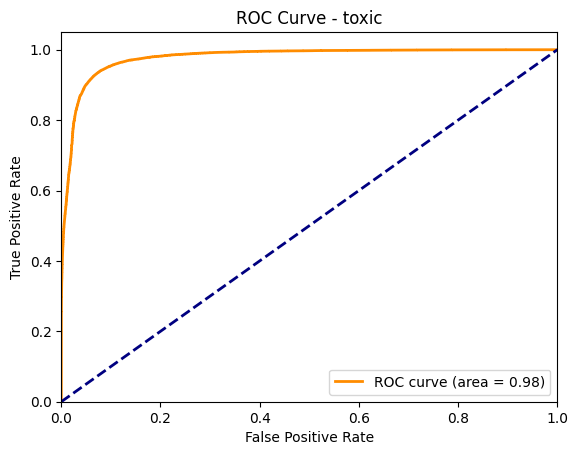

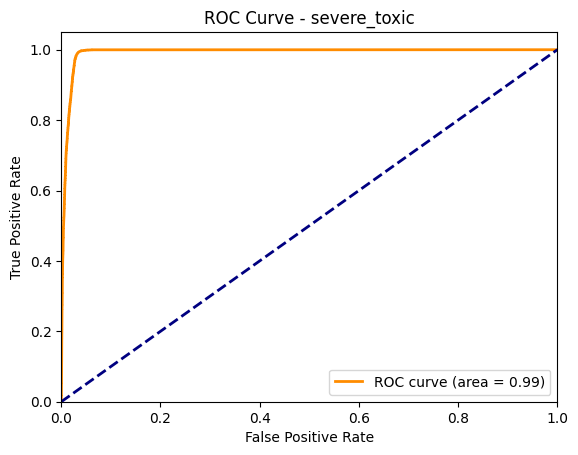

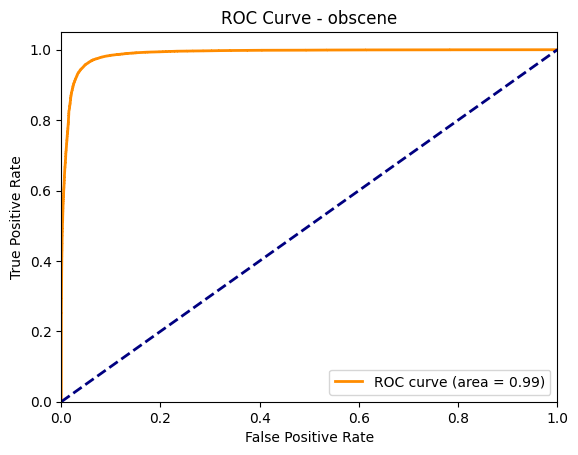

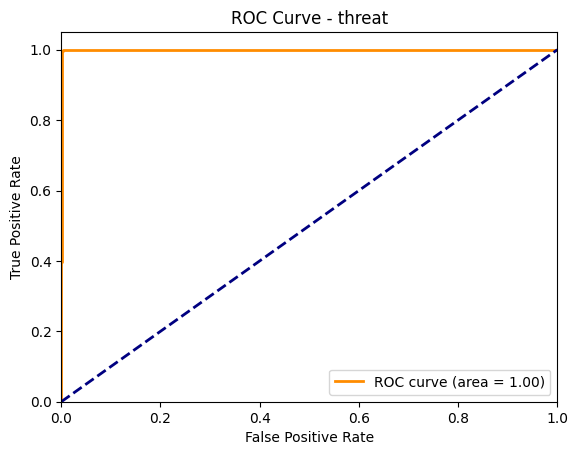

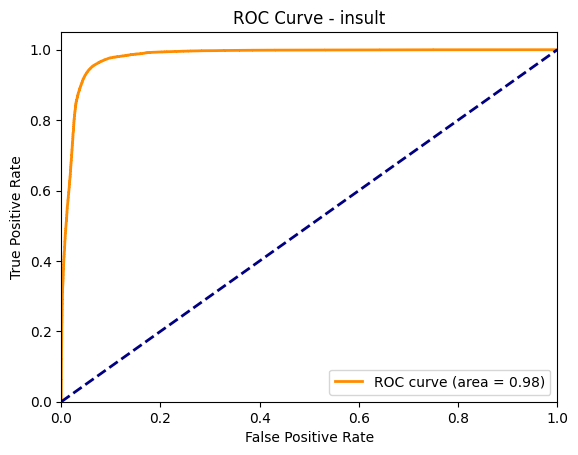

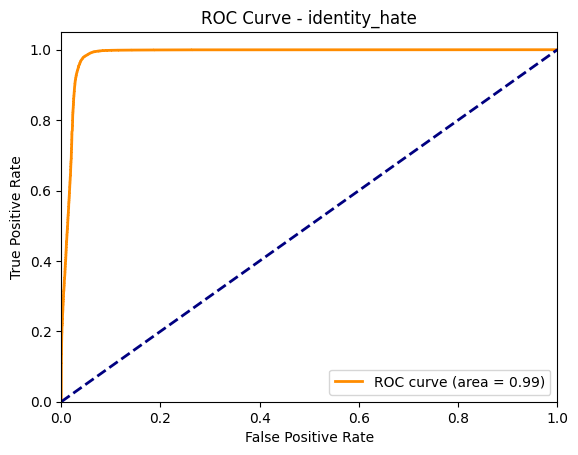

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
models = {}

for label in labels:
    X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(oversampled_data[label][0], oversampled_data[label][1], test_size=0.2, random_state=42)

    softmax_regression_model_label = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    softmax_regression_model_label.fit(X_train_label, y_train_label)
    
    y_pred_proba_label = softmax_regression_model_label.predict_proba(X_test_label)[:, 1]  # Probability of positive class
    fpr, tpr, thresholds = roc_curve(y_test_label, y_pred_proba_label)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {label}')
    plt.legend(loc="lower right")
    plt.show()

    models[label] = softmax_regression_model_label


**Autre affichage de ROC**

Category: toxic
Test accuracy: 0.9302732581310322
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     28854
           1       0.92      0.94      0.93     28857

    accuracy                           0.93     57711
   macro avg       0.93      0.93      0.93     57711
weighted avg       0.93      0.93      0.93     57711

Category: severe_toxic
Test accuracy: 0.9780031966577519
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     31656
           1       0.96      1.00      0.98     31535

    accuracy                           0.98     63191
   macro avg       0.98      0.98      0.98     63191
weighted avg       0.98      0.98      0.98     63191

Category: obscene
Test accuracy: 0.9543747621962315
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     30250
           1       0.95      0.96      0.95     30199

    accuracy           

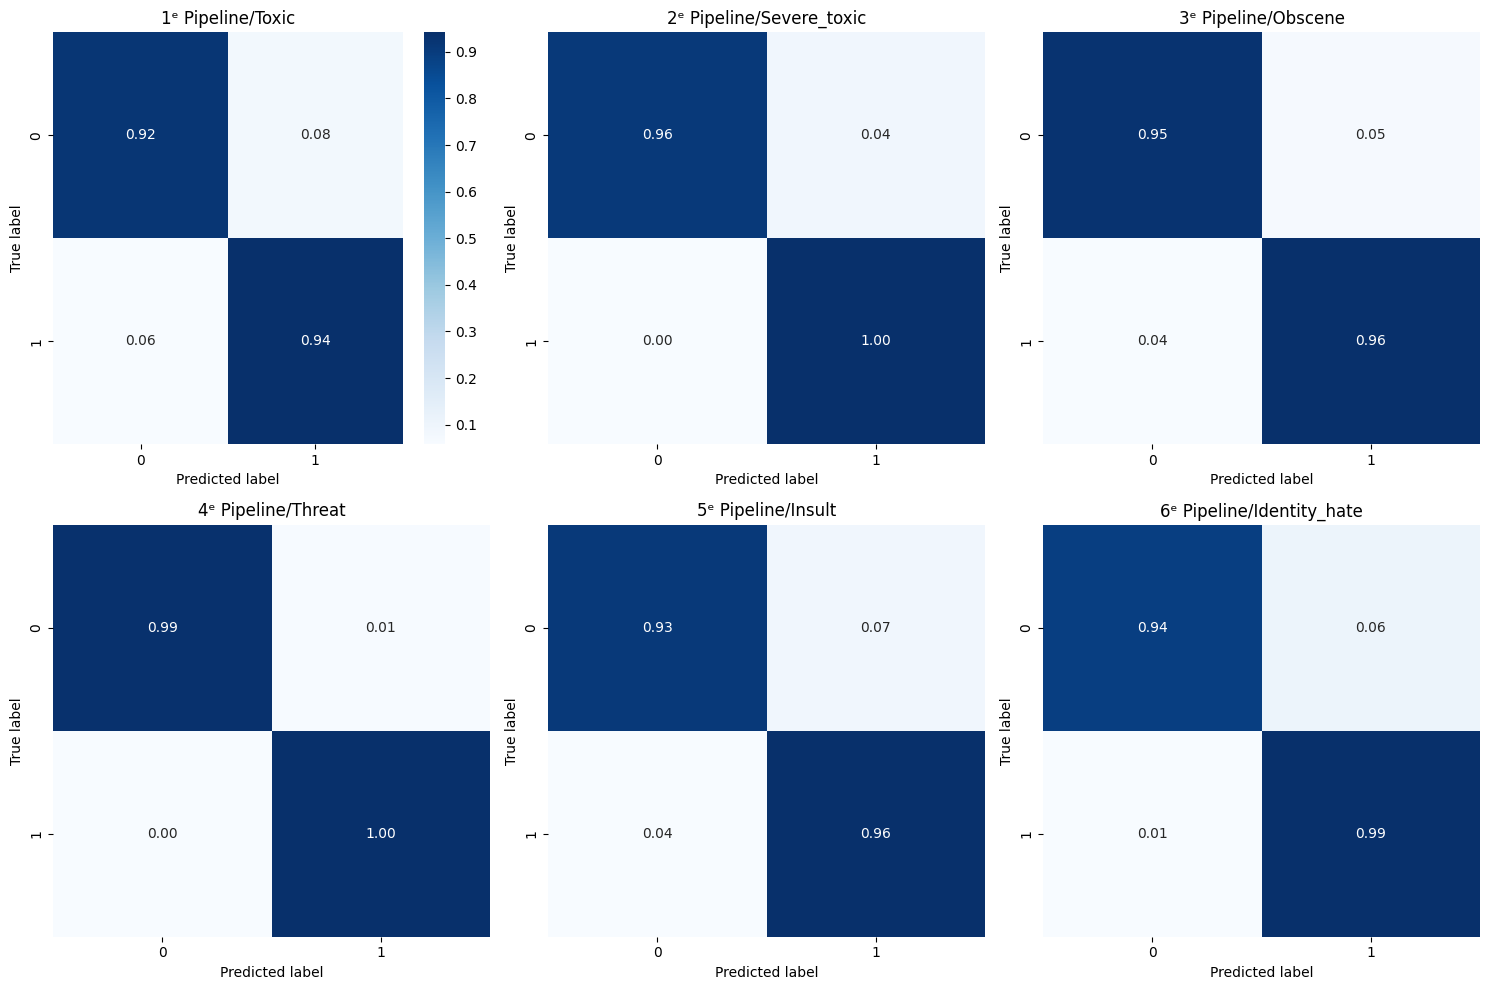

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Supposons que oversampled_data soit un dictionnaire contenant les données suréchantillonnées
# oversampled_data = {
#     'toxic': (X_train_toxic, y_train_toxic),
#     'severe_toxic': (X_train_severe_toxic, y_train_severe_toxic),
#     'obscene': (X_train_obscene, y_train_obscene),
#     'threat': (X_train_threat, y_train_threat),
#     'insult': (X_train_insult, y_train_insult),
#     'identity_hate': (X_train_identity_hate, y_train_identity_hate),
# }

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
models = {}
confusion_matrices = []

for label in labels:
    X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(
        oversampled_data[label][0], oversampled_data[label][1], test_size=0.2, random_state=42
    )

    softmax_regression_model_label = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    softmax_regression_model_label.fit(X_train_label, y_train_label)
    
    y_pred_label = softmax_regression_model_label.predict(X_test_label)

    accuracy_label = accuracy_score(y_test_label, y_pred_label)
    report_label = classification_report(y_test_label, y_pred_label)

    print(f'Category: {label}')
    print(f'Test accuracy: {accuracy_label}')
    print(report_label)

    # Confusion matrix
    cm = confusion_matrix(y_test_label, y_pred_label, normalize='true')
    confusion_matrices.append((label, cm))

    models[label] = softmax_regression_model_label

# Plotting confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (label, cm) in enumerate(confusion_matrices):
    ax = axes[i // 3, i % 3]
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', ax=ax, cbar=i == 0)
    ax.set_title(f'{i+1}ᵉ Pipeline/{label.capitalize()}')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

plt.tight_layout()
plt.show()


**Ce code entraîne un modèle de régression logistique multinomiale pour chaque classe de labels (toxic, severe_toxic, obscene, threat, insult, identity_hate) en utilisant les données d'entraînement sur-échantillonnées. Ensuite, il évalue la performance de chaque modèle en termes de précision et affiche les matrices de confusion normalisées.**

**Plus précisément, pour chaque classe :**

**Divise les données sur-échantillonnées en ensembles d'entraînement et de test.
Entraîne un modèle de régression logistique multinomiale sur les données d'entraînement.
Prédit les étiquettes de test.
Calcule la précision ainsi que le rapport de classification.
Calcule et stocke la matrice de confusion normalisée pour évaluer la performance du modèle.
Enfin, il trace les matrices de confusion normalisées pour chaque classe dans une grille matplotlib en utilisant seaborn pour la visualisation. Cela permet d'observer visuellement la performance des modèles pour chaque classe.**


**Submission Softmax**

In [43]:
submission = pd.DataFrame({'id': test_df['id']})
for label in labels:
    y_prob_label = softmax_regression_model_label.predict_proba(test_vect)[:, 1]
    submission[label] = y_prob_label

submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999986,0.999986,0.999986,0.999986,0.999986,0.999986
1,0000247867823ef7,0.010045,0.010045,0.010045,0.010045,0.010045,0.010045
2,00013b17ad220c46,0.260537,0.260537,0.260537,0.260537,0.260537,0.260537
3,00017563c3f7919a,0.002625,0.002625,0.002625,0.002625,0.002625,0.002625
4,00017695ad8997eb,0.230975,0.230975,0.230975,0.230975,0.230975,0.230975


**Dans ce code, une DataFrame appelée submission est créée pour stocker les prédictions de chaque modèle pour chaque classe. Pour chaque classe, les probabilités prédites sont calculées à l'aide de la méthode predict_proba du dernier modèle entraîné (softmax_regression_model_label) sur l'ensemble de données de test (test_vect). Ensuite, ces probabilités prédites sont ajoutées à la DataFrame submission sous forme de colonnes correspondant à chaque classe.**

**Enfin, la DataFrame submission est affichée, montrant les identifiants (id) des commentaires de test ainsi que les probabilités prédites pour chaque classe.**

In [44]:
submission.to_csv('submission_softmax.csv', index=False)

In [45]:
from sklearn.naive_bayes import MultinomialNB
models = {}

for label in labels:
    X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(oversampled_data[label][0],oversampled_data[label][1],test_size=0.2, random_state=42) 
    
    nb_model = MultinomialNB()
    nb_model.fit(X_train_label, y_train_label)
    
    y_pred_label = nb_model.predict(X_test_label)
    accuracy = accuracy_score(y_test_label, y_pred_label)
    report = classification_report(y_test_label, y_pred_label)
    
    print(f'Category: {label}')
    print(f'Test accuracy: {accuracy}')
    print(report)

    models[label] = nb_model

Category: toxic
Test accuracy: 0.8837829876453362
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     28854
           1       0.90      0.86      0.88     28857

    accuracy                           0.88     57711
   macro avg       0.88      0.88      0.88     57711
weighted avg       0.88      0.88      0.88     57711

Category: severe_toxic
Test accuracy: 0.9601050782548147
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     31656
           1       0.95      0.97      0.96     31535

    accuracy                           0.96     63191
   macro avg       0.96      0.96      0.96     63191
weighted avg       0.96      0.96      0.96     63191

Category: obscene
Test accuracy: 0.9058710648645966
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     30250
           1       0.92      0.89      0.90     30199

    accuracy           

**Ce code entraîne un modèle de classification naïve bayésienne multinomiale pour chaque classe de labels (toxic, severe_toxic, obscene, threat, insult, identity_hate) en utilisant les données d'entraînement sur-échantillonnées. Ensuite, il évalue la performance de chaque modèle en termes de précision et affiche le rapport de classification correspondant.**


**Plus précisément, pour chaque classe :**

**Divise les données sur-échantillonnées en ensembles d'entraînement et de test.
Entraîne un modèle de classification naïve bayésienne multinomiale sur les données d'entraînement.
Prédit les étiquettes de test.
Calcule la précision ainsi que le rapport de classification.
Stocke les modèles entraînés dans un dictionnaire models pour une utilisation ultérieure.
Cela permet d'évaluer la performance des modèles de classification naïve bayésienne multinomiale pour prédire chaque classe de toxicité.**

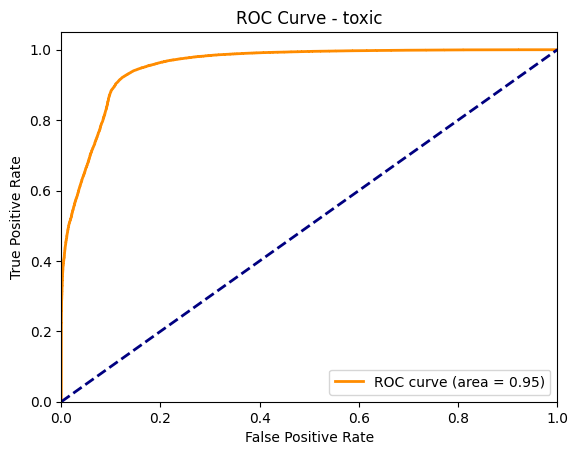

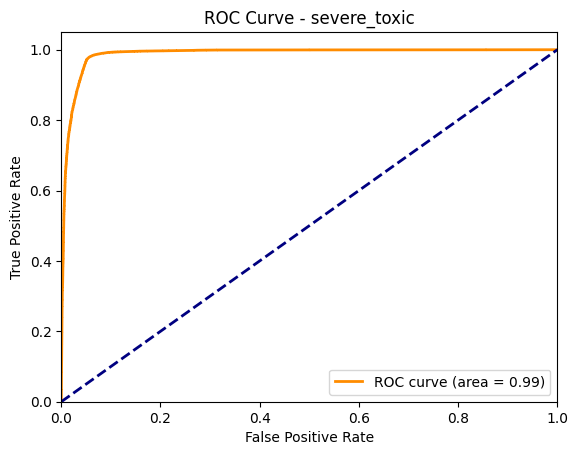

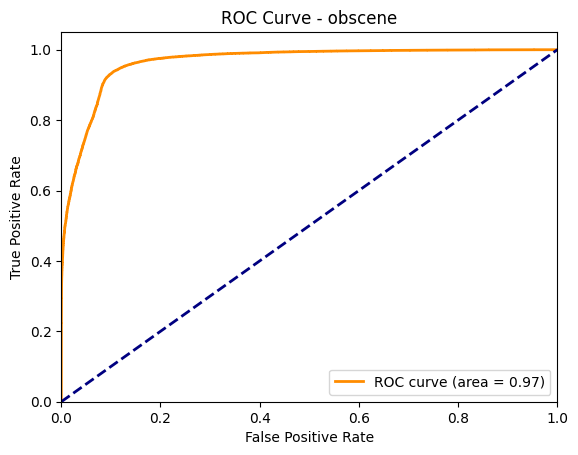

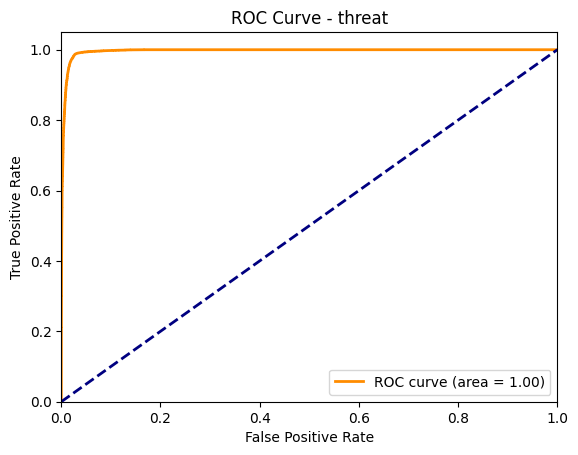

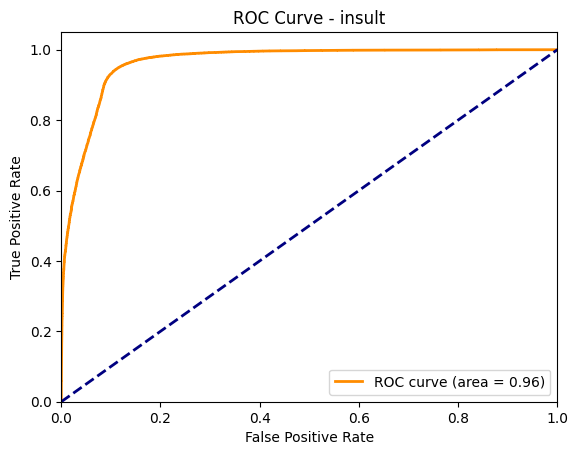

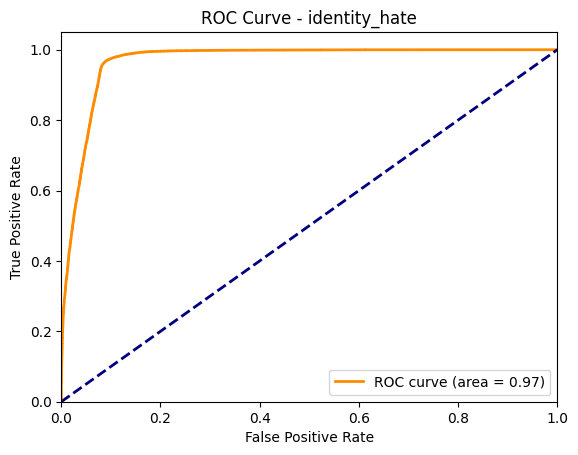

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
models = {}

for label in labels:
    X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(oversampled_data[label][0], oversampled_data[label][1], test_size=0.2, random_state=42)

    nb_model_label = MultinomialNB()
    nb_model_label.fit(X_train_label, y_train_label)
    
    y_pred_proba_label = nb_model_label.predict_proba(X_test_label)[:, 1]  # Probability of positive class
    fpr, tpr, thresholds = roc_curve(y_test_label, y_pred_proba_label)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {label}')
    plt.legend(loc="lower right")
    plt.show()

    models[label] = nb_model_label


**Ce code entraîne des modèles de classification naïve bayésienne multinomiale pour chaque classe de labels (toxic, severe_toxic, obscene, threat, insult, identity_hate) en utilisant les données d'entraînement sur-échantillonnées. Ensuite, il génère les courbes ROC pour évaluer la performance de chaque modèle en termes de trade-off entre le taux de vrais positifs et le taux de faux positifs.**

**Plus précisément, pour chaque classe :**

**Divise les données sur-échantillonnées en ensembles d'entraînement et de test.
Entraîne un modèle de classification naïve bayésienne multinomiale sur les données d'entraînement.
Prédit les probabilités de la classe positive pour les données de test.
Calcule le taux de faux positifs (FPR), le taux de vrais positifs (TPR) et les seuils pour les courbes ROC.
Trace la courbe ROC pour chaque classe, en affichant l'aire sous la courbe (ROC AUC).
Stocke les modèles entraînés dans un dictionnaire models pour une utilisation ultérieure.
Cela permet d'évaluer visuellement la performance des modèles de classification naïve bayésienne multinomiale pour prédire chaque classe de toxicité en fonction de différents seuils de classification.**

Category: toxic
Test accuracy: 0.8837829876453362
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     28854
           1       0.90      0.86      0.88     28857

    accuracy                           0.88     57711
   macro avg       0.88      0.88      0.88     57711
weighted avg       0.88      0.88      0.88     57711

Category: severe_toxic
Test accuracy: 0.9601050782548147
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     31656
           1       0.95      0.97      0.96     31535

    accuracy                           0.96     63191
   macro avg       0.96      0.96      0.96     63191
weighted avg       0.96      0.96      0.96     63191

Category: obscene
Test accuracy: 0.9058710648645966
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     30250
           1       0.92      0.89      0.90     30199

    accuracy           

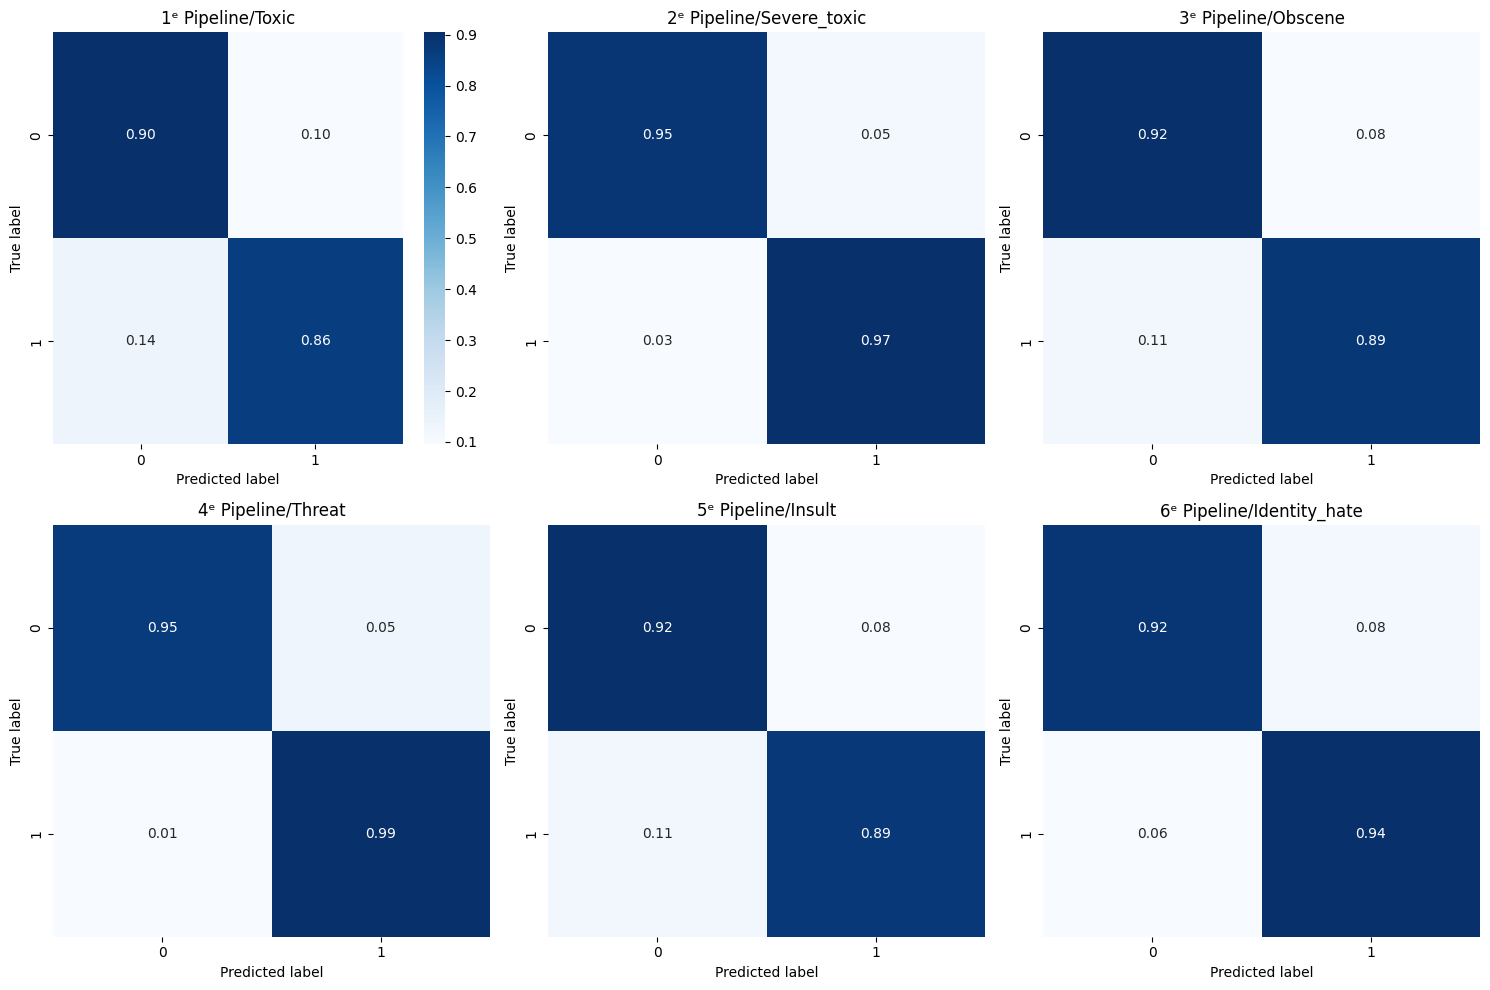

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Supposons que oversampled_data soit un dictionnaire contenant les données suréchantillonnées
# oversampled_data = {
#     'toxic': (X_train_toxic, y_train_toxic),
#     'severe_toxic': (X_train_severe_toxic, y_train_severe_toxic),
#     'obscene': (X_train_obscene, y_train_obscene),
#     'threat': (X_train_threat, y_train_threat),
#     'insult': (X_train_insult, y_train_insult),
#     'identity_hate': (X_train_identity_hate, y_train_identity_hate),
# }

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
models = {}
confusion_matrices = []

for label in labels:
    X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(
        oversampled_data[label][0], oversampled_data[label][1], test_size=0.2, random_state=42
    )

    nb_model = MultinomialNB()
    nb_model.fit(X_train_label, y_train_label)
    
    y_pred_label = nb_model.predict(X_test_label)
    accuracy = accuracy_score(y_test_label, y_pred_label)
    report = classification_report(y_test_label, y_pred_label)

    print(f'Category: {label}')
    print(f'Test accuracy: {accuracy}')
    print(report)

    # Confusion matrix
    cm = confusion_matrix(y_test_label, y_pred_label, normalize='true')
    confusion_matrices.append((label, cm))

    models[label] = nb_model

# Plotting confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (label, cm) in enumerate(confusion_matrices):
    ax = axes[i // 3, i % 3]
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', ax=ax, cbar=i == 0)
    ax.set_title(f'{i+1}ᵉ Pipeline/{label.capitalize()}')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

plt.tight_layout()
plt.show()


**Ce code entraîne des modèles de classification naïve bayésienne multinomiale pour chaque classe de labels (toxic, severe_toxic, obscene, threat, insult, identity_hate) en utilisant les données d'entraînement sur-échantillonnées. Ensuite, il affiche les matrices de confusion normalisées pour évaluer la performance de chaque modèle.**

**Plus précisément, pour chaque classe :**

**Divise les données sur-échantillonnées en ensembles d'entraînement et de test.
Entraîne un modèle de classification naïve bayésienne multinomiale sur les données d'entraînement.
Prédit les étiquettes de test.
Calcule la précision ainsi que le rapport de classification.
Calcule et stocke la matrice de confusion normalisée pour évaluer la performance du modèle.
Enfin, il affiche les matrices de confusion normalisées pour chaque classe dans une grille seaborn. Cela permet d'observer visuellement la performance des modèles pour chaque classe.**



**

In [47]:
submission_nb = pd.DataFrame({'id': test_df['id']})
for label in labels:
    y_prob_label = nb_model.predict_proba(test_vect)[:, 1]
    submission_nb[label] = y_prob_label

submission_nb.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.997133,0.997133,0.997133,0.997133,0.997133,0.997133
1,0000247867823ef7,0.011018,0.011018,0.011018,0.011018,0.011018,0.011018
2,00013b17ad220c46,0.156002,0.156002,0.156002,0.156002,0.156002,0.156002
3,00017563c3f7919a,0.008152,0.008152,0.008152,0.008152,0.008152,0.008152
4,00017695ad8997eb,0.188883,0.188883,0.188883,0.188883,0.188883,0.188883


**Dans ce code, une DataFrame submission_nb est créée pour stocker les prédictions de chaque modèle de classification naïve bayésienne multinomiale pour chaque classe de labels (toxic, severe_toxic, obscene, threat, insult, identity_hate). Pour chaque classe, les probabilités prédites sont calculées à l'aide de la méthode predict_proba du modèle naïf bayésien multinomial sur l'ensemble de données de test (test_vect). Ensuite, ces probabilités prédites sont ajoutées à la DataFrame submission_nb sous forme de colonnes correspondant à chaque classe.**

**Enfin, la DataFrame submission_nb est affichée, montrant les identifiants (id) des commentaires de test ainsi que les probabilités prédites pour chaque classe.**

In [48]:
submission_nb.to_csv('submission_nb.csv', index=False)